# Week 11: LDA

# Rasika Bhalerao

# Agenda

- LDA
 - Intuition / code
 - What to do with LDA

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import re
import zipfile
import gensim.downloader as api
from scipy.sparse import csr_matrix

Latent Dirichlet Allocation (LDA)

- Finds distributions of latent topics in a set of documents
 - A "topic" is a probability distribution of words
 - Each document will get a distribution of topics
- Topics are latent because they are not directly observed in the documents
 - (They are used to explain the words, which are directly observed)
- Documents and words each follow Dirichlet distributions because they are distributions of distributions


In [2]:
df = pd.DataFrame({
    'document': [
        'whiskers tail tail paw purr',
        'meow whiskers whiskers',
        'meow meow paw purr',
        'paw bark woof bark',
        'paw paw bark bark'
    ]
})

df.head()

,document
0,whiskers tail tail paw purr
1,meow whiskers whiskers
2,meow meow paw purr
3,paw bark woof bark
4,paw paw bark bark


In [3]:
topics = 2
vec = CountVectorizer()
X = vec.fit_transform(df['document'])
lda = LatentDirichletAllocation(n_components=topics)
doc_topics = lda.fit_transform(X)
doc_topics

array([[0.35494042, 0.64505958],
       [0.1268958 , 0.8731042 ],
       [0.14764829, 0.85235171],
       [0.89591346, 0.10408654],
       [0.8945496 , 0.1054504 ]])

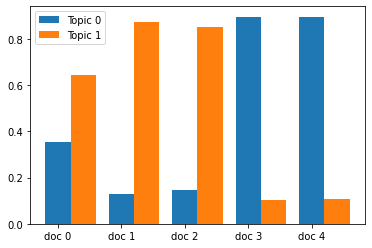

In [4]:
for topic in range(topics):
  plt.bar(
      [i + topic*0.8/topics for i in range(len(doc_topics))],
      [i[topic] for i in doc_topics],
      width=0.8/topics,
      label=f'Topic {topic}'
  )
plt.xticks(range(len(doc_topics)), [f'doc {i}' for i in range(len(doc_topics))])
plt.legend()
plt.show()

In [5]:
topic_words = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
topic_words

array([[0.32389311, 0.03675086, 0.31756928, 0.04209436, 0.1326246 ,
        0.03938289, 0.10768491],
       [0.03857177, 0.26589439, 0.12144097, 0.18406139, 0.08837149,
        0.26311235, 0.03854762]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


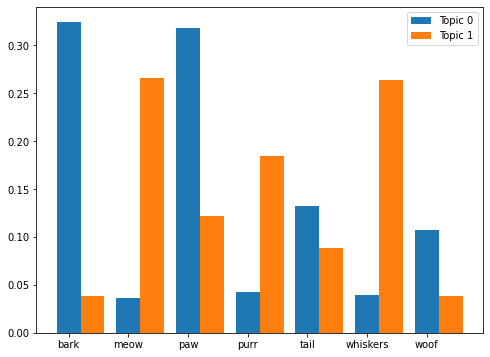

In [6]:
words = vec.get_feature_names()
plt.figure(figsize=(8, 6))
for topic in range(topics):
  plt.bar(
      [i + topic*0.8/topics for i in range(len(words))],
      topic_words[topic],
      width = 0.8/topics,
      label=f'Topic {topic}'
  )
plt.xticks(range(len(words)), words)
plt.legend()
plt.show()

LDA Algorithm

* Pick k - the number of topics
* Compile a vocabulary from the documents
* Randomly assign each word in the vocabulary to a topic
* Until all document distributions converge:
 - For each document d:
   1. For each word w in d, for each topic t:
     - Calculate P(t | d): percent of other words (not w) in d that are in t
     - Calculate P(w | t): percent of other documents (not d) that have word w
   2. Repeat step 1 until document d’s distribution converges
 - Update the probability of word w belonging to topic t: P(w | t) = P(t |d) * P(w | t)


### What to do with LDA?

In [7]:
# Analyze the major "themes" (topics) in the corpus
# Analyze the distribution of topics for each document
# Analyze important words for each topic

df = pd.DataFrame({
    'document': [
        'Your cat purrs and has fur.',
        'My cat meows and purrs.',
        'Your cat dislikes oranges.',
        'Oranges are citrus fruits.',
        'Oranges are fruits with Vitamin C.'
    ]
})

df.head()

,document
0,Your cat purrs and has fur.
1,My cat meows and purrs.
2,Your cat dislikes oranges.
3,Oranges are citrus fruits.
4,Oranges are fruits with Vitamin C.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


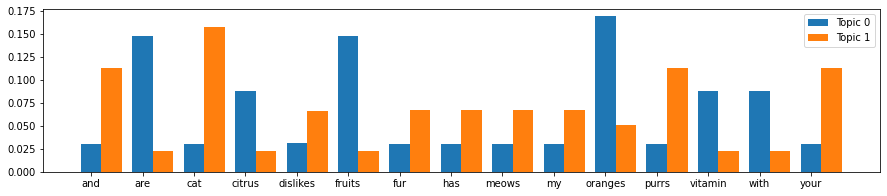

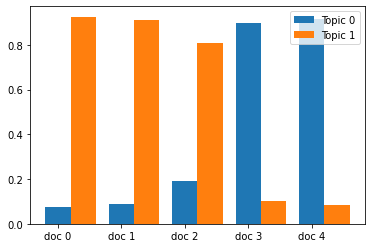

In [8]:
topics = 2
vec = CountVectorizer()
X = vec.fit_transform(df['document'])
lda = LatentDirichletAllocation(n_components=topics)
doc_topics = lda.fit_transform(X)
topic_words = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
words = vec.get_feature_names()
plt.figure(figsize=(15, 3))
for topic in range(topics):
  plt.bar(
      [i + topic*0.8/topics for i in range(len(words))],
      topic_words[topic],
      width = 0.8/topics,
      label=f'Topic {topic}'
  )
plt.xticks(range(len(words)), words)
plt.legend()
plt.show()
for topic in range(topics):
  plt.bar(
      [i + topic*0.8/topics for i in range(len(doc_topics))],
      [i[topic] for i in doc_topics],
      width=0.8/topics,
      label=f'Topic {topic}'
  )
plt.xticks(range(len(doc_topics)), [f'doc {i}' for i in range(len(doc_topics))])
plt.legend()
plt.show()

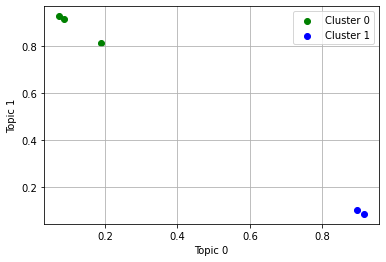

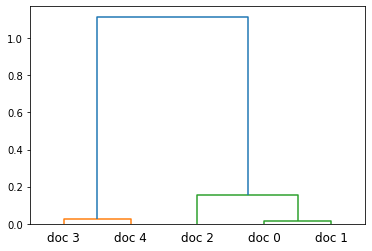

In [9]:
# Get the LDA vector for each document and use these vectors to cluster documents
# Or use LDA vectors as the features for each document and use them for supervised methods

n=2
clustering = AgglomerativeClustering(n_clusters=n).fit_predict(doc_topics)
colors = ['green', 'blue', 'turquoise', 'lightgreen', 'grey', 'lightblue', 'white', 'lightgrey']
for i in range(n):
  plt.scatter(
      doc_topics[clustering == i, 0],
      doc_topics[clustering == i, 1],
      c=colors[i],
      label=f'Cluster {i}')
plt.xlabel('Topic 0')
plt.ylabel('Topic 1')
plt.legend()
plt.grid()
plt.show()

clusters = linkage(
    pdist(
        pd.DataFrame(doc_topics)
    ),
    method='average'
)
row_dendr = dendrogram(clusters, labels=[f'doc {i}' for i in range(len(doc_topics))])

# You can also use Bag of words vectors for supervised/unsupervised tasks,
# and weight each word by how likely it is to be in a certain topic according to LDA